In [65]:
import requests
import re
from bs4 import BeautifulSoup
import jieba
import nltk
import string
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import csv
from sentence_transformers import SentenceTransformer, util
model1 = SentenceTransformer('paraphrase-MiniLM-L6-v2')
model2 = SentenceTransformer('all-mpnet-base-v2')

url = 'https://www.bbc.com/zhongwen/articles/c4gl97d2rzjo/simp'
site = requests.get(url)
site_soup = BeautifulSoup(site.text, 'html.parser')
# print(site_soup.prettify())

c:\Users\tempu\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\tempu\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [2]:
site_p = site_soup.find_all('p')[0:100]
text = ""
punc = "！？｡。＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏."

for p in site_p:
    text += str(p.get_text())


text.translate(str.maketrans('', '', string.punctuation))
text_re = re.sub(r"[%s]+" %punc, "", text)

tokens = jieba.lcut(text_re)
tokens_pd = pd.DataFrame(tokens)
tokens_pd.drop_duplicates(inplace=True)
tokens_pd.rename({0: "character"}, axis=1, inplace=True)
print(tokens_pd.shape)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\tempu\AppData\Local\Temp\jieba.cache
Loading model cost 1.706 seconds.
Prefix dict has been built successfully.


(747, 1)


In [123]:
HSK_nums = ['1', '2', '3', '4', '5', '6', '7_9']

HSK = pd.DataFrame()
for hsk in HSK_nums:
    hsk_df = pd.read_csv("../data/Chinese/HSK/HSK"+hsk+".tsv", sep="\t", header=None)
    hsk_df.drop(0, axis=1, inplace=True)
    hsk_df.rename(columns={1: "character", 2: "pinyin", 3: "definition"}, inplace=True)
    hsk_df.insert(loc=2, column="HSK", value=[hsk]*hsk_df.shape[0])
    hsk_df["embedding"] = hsk_df["definition"].map(model1.encode)
    HSK = pd.concat([HSK, hsk_df])
HSK.reset_index(inplace=True, drop=True)
HSK.head()

,character,pinyin,HSK,definition,embedding
0,爱,ài,1,"love, like, be fond of, be keen on, cherish, b...","[0.37996447, 0.29299688, 0.55704415, 0.0736245..."
1,爱好,àihào,1,"love, like, be fond of, be keen on","[0.4404698, 0.29555953, 0.5669606, -0.0190896,..."
2,爸爸,bàba,1,"old man, father, papa, pappa, daddy, pa, beget...","[0.05222196, 0.18916288, 0.2597713, -0.585589,..."
3,白,bái,1,"white, clear, pure, plain, wrongly written/mis...","[-0.17480375, 0.23118941, -0.27152503, 0.10098..."
4,八,bā,1,det.: eight,"[0.25673103, 0.25089717, 0.5315905, -0.3529175..."


In [145]:
cos_sim = []
for ii in range(1,HSK.shape[0]):
    cos_sim.append(model1.similarity(HSK["embedding"][0], HSK["embedding"][ii])[0][0].float())
HSK.iloc[int(np.argmax(cos_sim)+1),1]
    

'爱好'

In [ ]:
HSK_nums = ['1', '2', '3', '4', '5', '6', '7_9']

HSK2 = pd.DataFrame()
for hsk in HSK_nums:
    hsk_df = pd.read_csv("../data/Chinese/HSK/HSK"+hsk+".tsv", sep="\t", header=None)
    hsk_df.drop(0, axis=1, inplace=True)
    hsk_df.rename(columns={1: "character", 2: "pinyin", 3: "definition"}, inplace=True)
    hsk_df.insert(loc=2,column="HSK",value=[hsk]*hsk_df.shape[0])
    hsk_df["embedding"] = hsk_df["definition"].map(model2.encode)
    HSK2 = pd.concat([HSK, hsk_df])
HSK2.reset_index(inplace=True, drop=True)
HSK2.head()

,index,character,pinyin,HSK,definition,embedding
0,0.0,爱,ài,1,"love, like, be fond of, be keen on, cherish, b...","[0.37996447, 0.29299688, 0.55704415, 0.0736245..."
1,1.0,爱好,àihào,1,"love, like, be fond of, be keen on","[0.4404698, 0.29555953, 0.5669606, -0.0190896,..."
2,2.0,爸爸,bàba,1,"old man, father, papa, pappa, daddy, pa, beget...","[0.05222196, 0.18916288, 0.2597713, -0.585589,..."
3,3.0,白,bái,1,"white, clear, pure, plain, wrongly written/mis...","[-0.17480375, 0.23118941, -0.27152503, 0.10098..."
4,4.0,八,bā,1,det.: eight,"[0.25673103, 0.25089717, 0.5315905, -0.3529175..."


In [152]:
tokens_pd.head()

,character
0,图像
1,来源
2,Getty
3,
4,Images


In [160]:
HSK.shape

(11036, 6)

In [148]:
tokens_embed = pd.merge(left=tokens_pd, right=HSK, how='inner', on="character")
tokens_embed2 = pd.merge(left=tokens_pd, right=HSK2, how='inner', on="character")

In [ ]:
HSK[HSK['']]

In [153]:
tokens_embed.head()

,character,index,pinyin,HSK,definition,embedding
0,图像,4156,túxiàng,7_9,"picture, graph, icon, image","[-0.13980588, 0.34705573, -0.3828236, -0.55116..."
1,来源,454,láiyuán,4,"resource, wellspring, origin, provenance, quar...","[-0.05992677, -0.066163205, 0.0572199, -0.0089..."
2,今年,175,jīnnián,1,this year,"[-0.11772831, -0.09042055, 0.22076279, -0.1926..."
3,以来,828,yǐlái,3,since,"[0.014946421, 0.3638214, 0.09179747, -0.315277..."
4,刺激,124,cìjī,4,"stimulate, provoke, irritate, upset","[-0.14591263, -0.35047492, 0.57938576, 0.28862..."


In [68]:
tokens_embed.dropna(inplace=True)
tokens_embed2.dropna(inplace=True)

In [82]:
tokens_embed2.head()

,character,pinyin,HSK,definition,embedding
0,图像,túxiàng,7_9,"picture, graph, icon, image","[-0.13980578, 0.34705564, -0.38282347, -0.5511..."
1,图像,túxiàng,7_9,"picture, graph, icon, image","[-0.031714417, -0.08117082, -0.03150031, 0.019..."
2,来源,láiyuán,4,"resource, wellspring, origin, provenance, quar...","[-0.05992676, -0.06616323, 0.057219807, -0.008..."
6,今年,jīnnián,1,this year,"[-0.11772822, -0.090420365, 0.22076243, -0.192..."
8,以来,yǐlái,3,since,"[0.01494664, 0.36382112, 0.09179721, -0.315277..."


In [36]:
type(tokens_embed.iloc[0,4])

numpy.ndarray

In [74]:
cos_sim = []
for ii in range(1,tokens_embed.index.size):
    cos_sim.append(model1.similarity(tokens_embed.iloc[0,4], tokens_embed.iloc[ii,4])[0][0].float())
    
cos_sim2 = []
for ii in range(1,tokens_embed.index.size):
    cos_sim2.append(model2.similarity(tokens_embed2.iloc[0,4], tokens_embed2.iloc[ii,4])[0][0].float())

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x384 and 768x1)

In [72]:
tokens_embed.iloc[int(np.argmax(cos_sim)),0]

'有'

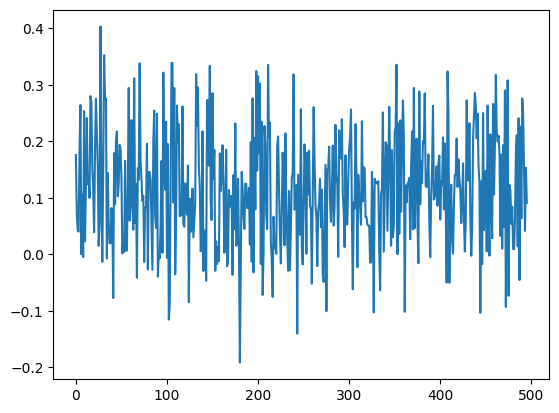

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cos_sim)
plt.plot(cos_sim2)